### Link to results
[Proportion of peaks with hits](#peaks-with-hits)

[Examples of motif hits](#example-hits)

[Homotypic density of motifs in peaks](#density)

[Co-occurrence of motifs in peaks](#co-occurrence)

[Distance between co-occurring motifs](#distance)

# Compare the different peaks that are unique to ChIP-seq, unique to CUT&RUN, or shared by both

In [1]:
import os
os.chdir('/home/katie/bp_repo/reports/')

from util import import_shap_scores, import_peak_table
from util import trim_motif_by_ic
from util import figure_to_vdom_image
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from IPython.display import display
import tqdm
tqdm.tqdm_notebook()

/tmp/ipykernel_21390/2372770853.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm.tqdm_notebook()


0it [00:00, ?it/s]

## a) Is there a difference in these peaks in terms of which motifs have hits?

#### game plannnn

1) Load in all motif hits for ChIP-seq and CUT&RUN
2) Subset motif hits to peaks that are unique to ChIP-seq, unique to CUT&RUN, or shared (2 sets of shared?)
3) Plot motif pattern distributions across different peak types—I think it would be relative prevalence of patterns, so they would sum up to the total number of motif hits IN THAT SUBSET OF PEAKS

In [43]:
# !bedtools intersect -v -a /home/katie/bp_repo/research/data/cutnrun/FOSL2/FOSL2_with_names.tsv -b /home/katie/bp_repo/research/data/chip-seq/FOSL2/FOSL2.bed > /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/FOSL2_unique_cutnrun_no_chip_overlap
# !bedtools intersect -v -a /home/katie/bp_repo/research/data/cutnrun/CTCF/CTCF_with_names.tsv -b /home/katie/bp_repo/research/data/chip-seq/CTCF/CTCF.bed > /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/CTCF_unique_cutnrun_no_chip_overlap
# !bedtools intersect -v -a /home/katie/bp_repo/research/data/chip-seq/FOSL2/FOSL2.bed -b /home/katie/bp_repo/research/data/cutnrun/FOSL2/FOSL2.bed > /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/FOSL2_unique_chip_no_cutnrun_overlap

# !bedtools intersect -u -a /home/katie/bp_repo/research/data/cutnrun/FOSL2/FOSL2_with_names.tsv -b /home/katie/bp_repo/research/data/chip-seq/FOSL2/FOSL2.bed > /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/FOSL2_unique_cutnrun_with_any_chip_overlap
# !bedtools intersect -u -a /home/katie/bp_repo/research/data/cutnrun/CTCF/CTCF_with_names.tsv -b /home/katie/bp_repo/research/data/chip-seq/CTCF/CTCF.bed > /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/CTCF_unique_cutnrun_with_any_chip_overlap



In [2]:
# load in basic peak tables
CTCF_cutnrun = import_peak_table(['/home/katie/bp_repo/research/data/cutnrun/CTCF/CTCF.bed'])
CTCF_chip = import_peak_table(['/home/katie/bp_repo/research/data/chip-seq/CTCF/CTCF.bed'])
FOSL2_cutnrun = import_peak_table(['/home/katie/bp_repo/research/data/cutnrun/FOSL2/FOSL2.bed'])
FOSL2_chip = import_peak_table(['/home/katie/bp_repo/research/data/chip-seq/FOSL2/FOSL2.bed'])

In [20]:
# add names if you load in original CTCF.bed or FOSL2.bed file. now this code is saved under CTCF_with_names.tsv & FOSL2
# FOSL2_cutnrun['name'] = list(range(len(FOSL2_cutnrun)))
# FOSL2_cutnrun.loc[:, FOSL2_cutnrun.columns != 'i9']   # stupid way to bring it back down to 20 columns. who needs that column anywayyyy
# FOSL2_cutnrun.to_csv('/home/katie/bp_repo/research/data/cutnrun/FOSL2/FOSL2_with_names.tsv', sep='\t', index=False)

In [3]:
# load in peaks unique to certain assay
CTCF_unique_cutnrun = import_peak_table(['/home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/CTCF_unique_cutnrun_no_chip_overlap'])
CTCF_unique_chipseq = import_peak_table(['/home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/CTCF_unique_chip_no_cutnrun_overlap'])
FOSL2_unique_cutnrun = import_peak_table(['/home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/FOSL2_unique_cutnrun_no_chip_overlap'])
FOSL2_unique_chipseq = import_peak_table(['/home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/FOSL2_unique_chip_no_cutnrun_overlap'])

# load in peaks that overlap between both assays
CTCF_cutnrun_overlapping_chip = import_peak_table(['/home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/CTCF_unique_cutnrun_with_any_chip_overlap'])
CTCF_chip_overlapping_cutnrun = import_peak_table(['/home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/CTCF_unique_chip_with_any_cutnrun_overlap'])
FOSL2_cutnrun_overlapping_chip = import_peak_table(['/home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/FOSL2_unique_cutnrun_with_any_chip_overlap'])
FOSL2_chip_overlapping_cutnrun = import_peak_table(['/home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/FOSL2_unique_chip_with_any_cutnrun_overlap'])



In [4]:
# load in motif hits
CTCF_motifs_cutnrun = import_peak_table(['/home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_cutnrun_feb7/tfm_matches.bed'])
CTCF_motifs_chip = import_peak_table(['/home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_chipseq_feb7/tfm_matches.bed'])

FOSL2_motifs_cutnrun = import_peak_table(['/home/katie/bp_repo/reports/tfm_hits/FOSL2/fosl2_cutnrun_feb7/tfm_matches.bed'])
FOSL2_motifs_chip = import_peak_table(['/home/katie/bp_repo/reports/tfm_hits/FOSL2/fosl2_chipseq_feb7/tfm_matches.bed'])

In [5]:
# subset motif hits to peaks UNIQUE to chip-seq
peaks = list(int(i[5:]) for i in CTCF_unique_chipseq.name.unique())  # cut off the "Peak_" before, like "Peak_28"
CTCF_motifs_unique_to_chip = CTCF_motifs_chip.loc[np.isin(CTCF_motifs_chip.strand, peaks)]  # 19,468 hits

peaks = list(int(i[5:]) for i in FOSL2_unique_chipseq.name.unique())  # cut off the "Peak_" before, like "Peak_28"
FOSL2_motifs_unique_to_chip = FOSL2_motifs_chip.loc[np.isin(FOSL2_motifs_chip.strand, peaks)]  # 16,147 hits

In [6]:
# subset motif hits to peaks UNIQUE to cutnrun
peaks = CTCF_unique_cutnrun.name.unique()  # DON'T NEED TO CUT ANYTHING OFF
CTCF_motifs_unique_to_cutnrun = CTCF_motifs_cutnrun.loc[np.isin(CTCF_motifs_cutnrun.strand, peaks)]  # 32,957 hits

peaks = FOSL2_unique_cutnrun.name.unique()  # DON'T NEED TO CUT ANYTHING OFF
FOSL2_motifs_unique_to_cutnrun = FOSL2_motifs_cutnrun.loc[np.isin(FOSL2_motifs_cutnrun.strand, peaks)]  # 58,276 hits

In [7]:
# subset motif hits to peaks of chip-seq that overlap cutnrun
peaks = list(int(i[5:]) for i in CTCF_chip_overlapping_cutnrun.name.unique())  # cut off the "Peak_" before, like "Peak_28"
CTCF_motifs_chip_overlapping_cutnrun = CTCF_motifs_chip.loc[np.isin(CTCF_motifs_chip.strand, peaks)]  # 134,086 hits

peaks = list(int(i[5:]) for i in FOSL2_chip_overlapping_cutnrun.name.unique())  # cut off the "Peak_" before, like "Peak_28"
FOSL2_motifs_chip_overlapping_cutnrun = FOSL2_motifs_chip.loc[np.isin(FOSL2_motifs_chip.strand, peaks)] # 75,185 hits

In [8]:
# subset motif hits to peaks of cutnrun that overlap chip-seq
peaks = CTCF_cutnrun_overlapping_chip.name.unique()  # DON'T NEED TO CUT ANYTHING OFF
CTCF_motifs_cutnrun_overlapping_chip = CTCF_motifs_cutnrun.loc[np.isin(CTCF_motifs_cutnrun.strand, peaks)]  # 108,594 hits

peaks = FOSL2_cutnrun_overlapping_chip.name.unique()  # DON'T NEED TO CUT ANYTHING OFF
FOSL2_motifs_cutnrun_overlapping_chip = FOSL2_motifs_cutnrun.loc[np.isin(FOSL2_motifs_cutnrun.strand, peaks)]  # 97,714 hits



### graph time :]

In [9]:
plt.rcParams['figure.dpi'] = 100

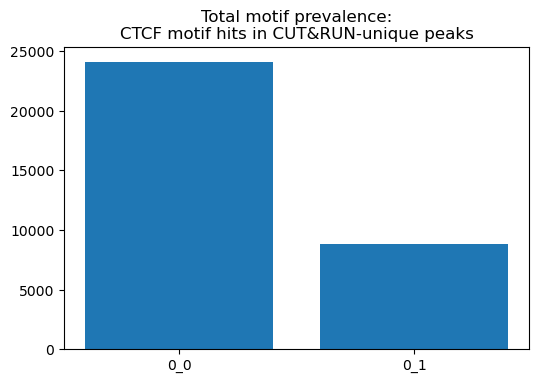

In [10]:
fig = plt.bar(x = CTCF_motifs_unique_to_cutnrun.name.unique(), 
              height = pd.value_counts(CTCF_motifs_unique_to_cutnrun.name))
fig = plt.title('Total motif prevalence:\nCTCF motif hits in CUT&RUN-unique peaks')

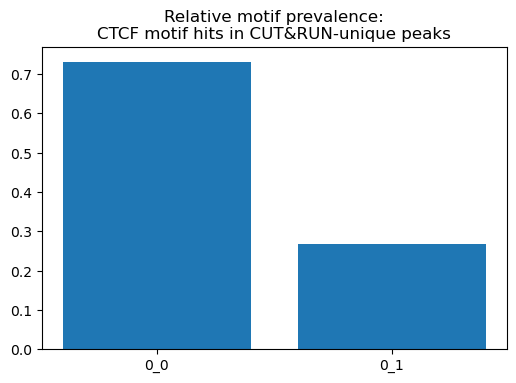

In [147]:
fig = plt.bar(x = CTCF_motifs_unique_to_cutnrun.name.unique(), 
              height = pd.value_counts(CTCF_motifs_unique_to_cutnrun.name) / len(CTCF_motifs_unique_to_cutnrun))
fig = plt.title('Relative motif prevalence:\nCTCF motif hits in CUT&RUN-unique peaks')

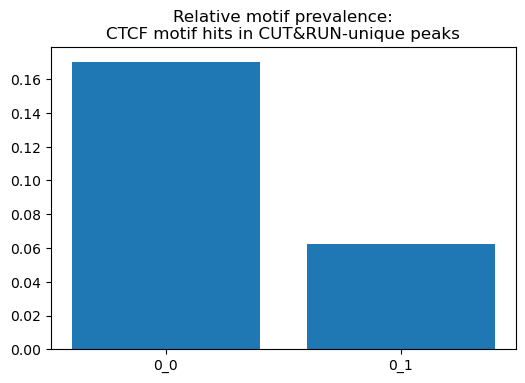

In [11]:
fig = plt.bar(x = CTCF_motifs_unique_to_cutnrun.name.unique(), 
              height = pd.value_counts(CTCF_motifs_unique_to_cutnrun.name) / len(CTCF_motifs_cutnrun))
fig = plt.title('Relative motif prevalence:\nCTCF motif hits in CUT&RUN-unique peaks')

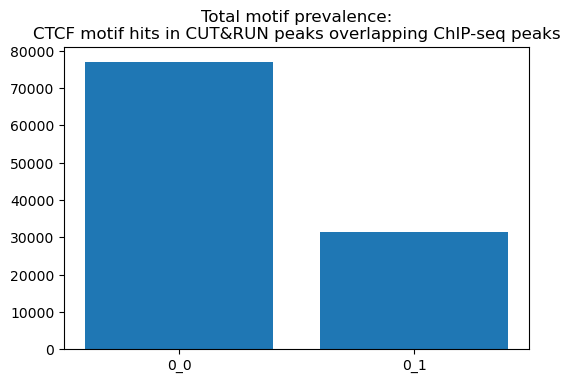

In [225]:
fig = plt.bar(x = CTCF_motifs_cutnrun_overlapping_chip.name.unique(), 
              height = pd.value_counts(CTCF_motifs_cutnrun_overlapping_chip.name))
fig = plt.title('Total motif prevalence:\nCTCF motif hits in CUT&RUN peaks overlapping ChIP-seq peaks')

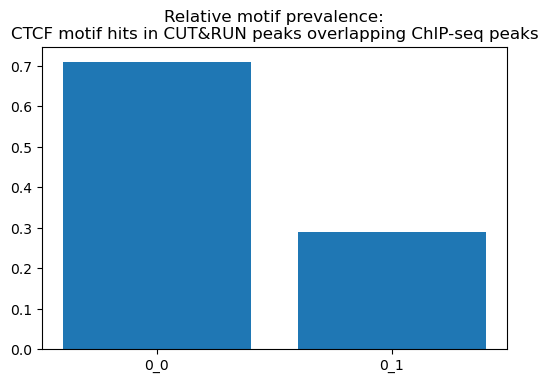

In [226]:
fig = plt.bar(x = CTCF_motifs_cutnrun_overlapping_chip.name.unique(), 
              height = pd.value_counts(CTCF_motifs_cutnrun_overlapping_chip.name) / len(CTCF_motifs_cutnrun_overlapping_chip))
fig = plt.title('Relative motif prevalence:\nCTCF motif hits in CUT&RUN peaks overlapping ChIP-seq peaks')

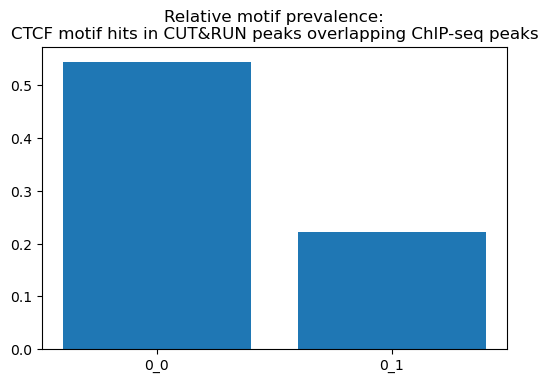

In [12]:
fig = plt.bar(x = CTCF_motifs_cutnrun_overlapping_chip.name.unique(), 
              height = pd.value_counts(CTCF_motifs_cutnrun_overlapping_chip.name) / len(CTCF_motifs_cutnrun))
fig = plt.title('Relative motif prevalence:\nCTCF motif hits in CUT&RUN peaks overlapping ChIP-seq peaks')

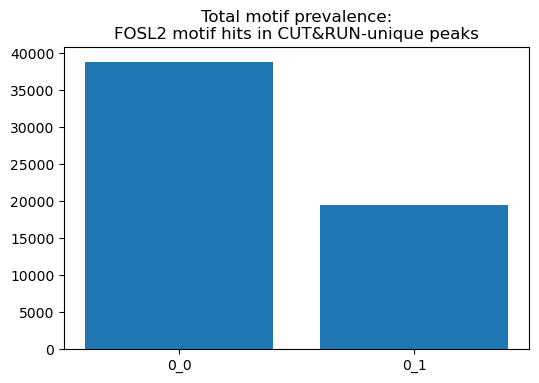

In [151]:
fig = plt.bar(x = FOSL2_motifs_unique_to_cutnrun.name.unique(), 
              height = pd.value_counts(FOSL2_motifs_unique_to_cutnrun.name))
fig = plt.title('Total motif prevalence:\nFOSL2 motif hits in CUT&RUN-unique peaks')

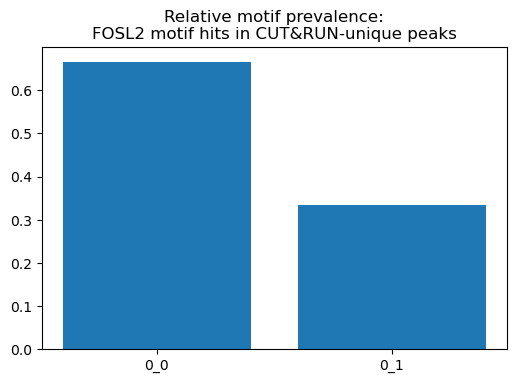

In [152]:
fig = plt.bar(x = FOSL2_motifs_unique_to_cutnrun.name.unique(), 
              height = pd.value_counts(FOSL2_motifs_unique_to_cutnrun.name) / len(FOSL2_motifs_unique_to_cutnrun))
fig = plt.title('Relative motif prevalence:\nFOSL2 motif hits in CUT&RUN-unique peaks')

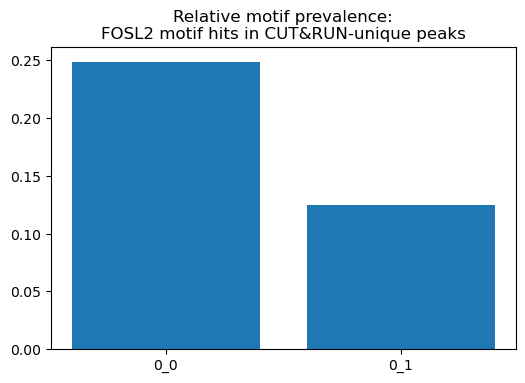

In [14]:
fig = plt.bar(x = FOSL2_motifs_unique_to_cutnrun.name.unique(), 
              height = pd.value_counts(FOSL2_motifs_unique_to_cutnrun.name) / len(FOSL2_motifs_cutnrun))
fig = plt.title('Relative motif prevalence:\nFOSL2 motif hits in CUT&RUN-unique peaks')

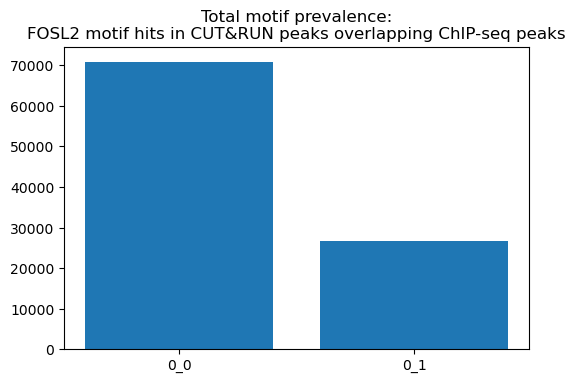

In [227]:
fig = plt.bar(x = FOSL2_motifs_cutnrun_overlapping_chip.name.unique(), 
              height = pd.value_counts(FOSL2_motifs_cutnrun_overlapping_chip.name))
fig = plt.title('Total motif prevalence:\nFOSL2 motif hits in CUT&RUN peaks overlapping ChIP-seq peaks')

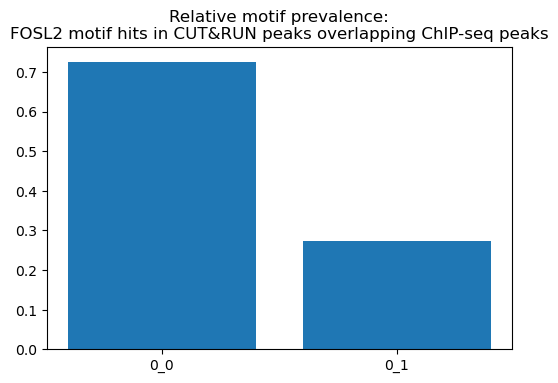

In [228]:
fig = plt.bar(x = FOSL2_motifs_cutnrun_overlapping_chip.name.unique(), 
              height = pd.value_counts(FOSL2_motifs_cutnrun_overlapping_chip.name) / len(FOSL2_motifs_cutnrun_overlapping_chip))
fig = plt.title('Relative motif prevalence:\nFOSL2 motif hits in CUT&RUN peaks overlapping ChIP-seq peaks')

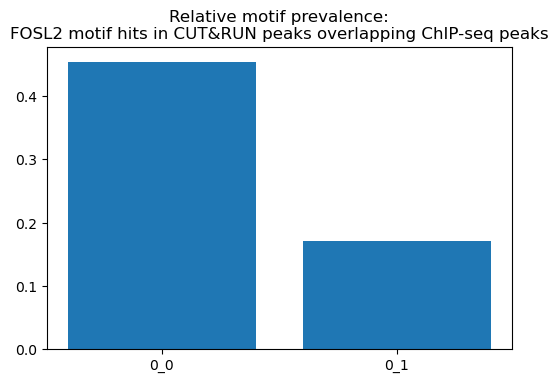

In [15]:
fig = plt.bar(x = FOSL2_motifs_cutnrun_overlapping_chip.name.unique(), 
              height = pd.value_counts(FOSL2_motifs_cutnrun_overlapping_chip.name) / len(FOSL2_motifs_cutnrun))
fig = plt.title('Relative motif prevalence:\nFOSL2 motif hits in CUT&RUN peaks overlapping ChIP-seq peaks')

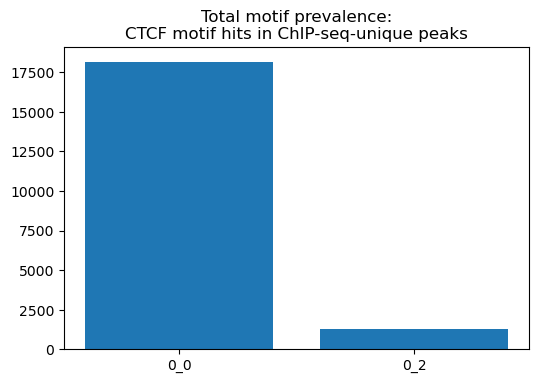

In [142]:
fig = plt.bar(x = CTCF_motifs_unique_to_chip.name.unique(), 
              height = pd.value_counts(CTCF_motifs_unique_to_chip.name))
fig = plt.title('Total motif prevalence:\nCTCF motif hits in ChIP-seq-unique peaks')

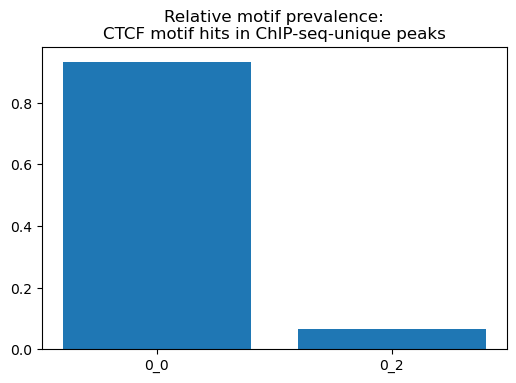

In [143]:
fig = plt.bar(x = CTCF_motifs_unique_to_chip.name.unique(), 
              height = pd.value_counts(CTCF_motifs_unique_to_chip.name) / len(CTCF_motifs_unique_to_chip))
fig = plt.title('Relative motif prevalence:\nCTCF motif hits in ChIP-seq-unique peaks')

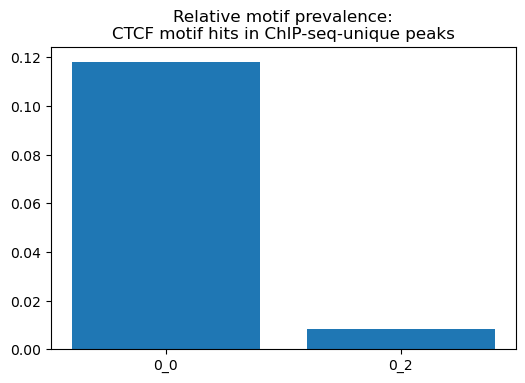

In [16]:
fig = plt.bar(x = CTCF_motifs_unique_to_chip.name.unique(), 
              height = pd.value_counts(CTCF_motifs_unique_to_chip.name) / len(CTCF_motifs_chip))
fig = plt.title('Relative motif prevalence:\nCTCF motif hits in ChIP-seq-unique peaks')

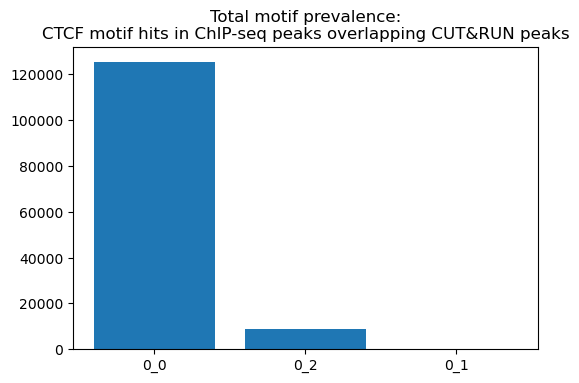

In [155]:
fig = plt.bar(x = CTCF_motifs_chip_overlapping_cutnrun.name.unique(), 
              height = pd.value_counts(CTCF_motifs_chip_overlapping_cutnrun.name))
fig = plt.title('Total motif prevalence:\nCTCF motif hits in ChIP-seq peaks overlapping CUT&RUN peaks')

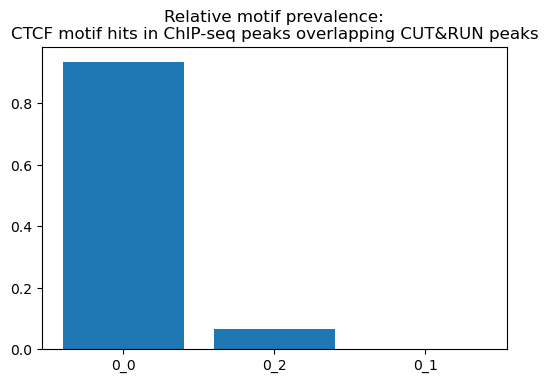

In [156]:
fig = plt.bar(x = CTCF_motifs_chip_overlapping_cutnrun.name.unique(), 
              height = pd.value_counts(CTCF_motifs_chip_overlapping_cutnrun.name) / len(CTCF_motifs_chip_overlapping_cutnrun.name))
fig = plt.title('Relative motif prevalence:\nCTCF motif hits in ChIP-seq peaks overlapping CUT&RUN peaks')

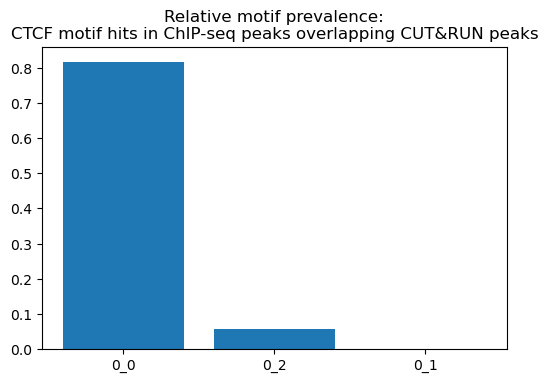

In [18]:
fig = plt.bar(x = CTCF_motifs_chip_overlapping_cutnrun.name.unique(), 
              height = pd.value_counts(CTCF_motifs_chip_overlapping_cutnrun.name) / len(CTCF_motifs_chip))
fig = plt.title('Relative motif prevalence:\nCTCF motif hits in ChIP-seq peaks overlapping CUT&RUN peaks')

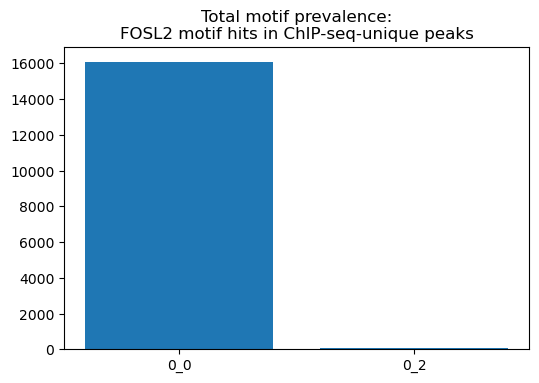

In [140]:
fig = plt.bar(x = FOSL2_motifs_unique_to_chip.name.unique(), 
              height = pd.value_counts(FOSL2_motifs_unique_to_chip.name))
fig = plt.title('Total motif prevalence:\nFOSL2 motif hits in ChIP-seq-unique peaks')

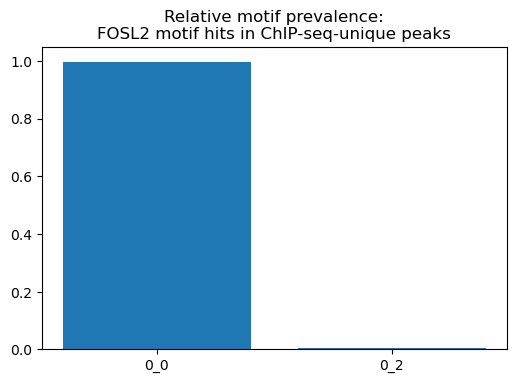

In [141]:
fig = plt.bar(x = FOSL2_motifs_unique_to_chip.name.unique(), 
              height = pd.value_counts(FOSL2_motifs_unique_to_chip.name) / len(FOSL2_motifs_unique_to_chip))
fig = plt.title('Relative motif prevalence:\nFOSL2 motif hits in ChIP-seq-unique peaks')

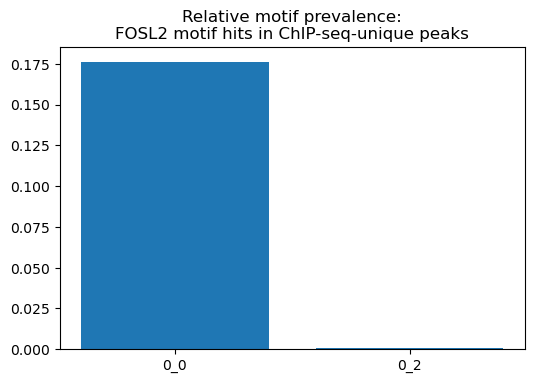

In [19]:
fig = plt.bar(x = FOSL2_motifs_unique_to_chip.name.unique(), 
              height = pd.value_counts(FOSL2_motifs_unique_to_chip.name) / len(FOSL2_motifs_chip))
fig = plt.title('Relative motif prevalence:\nFOSL2 motif hits in ChIP-seq-unique peaks')

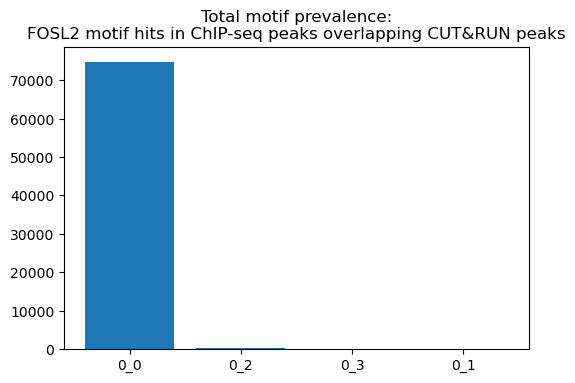

In [157]:
fig = plt.bar(x = FOSL2_motifs_chip_overlapping_cutnrun.name.unique(), 
              height = pd.value_counts(FOSL2_motifs_chip_overlapping_cutnrun.name))
fig = plt.title('Total motif prevalence:\nFOSL2 motif hits in ChIP-seq peaks overlapping CUT&RUN peaks')

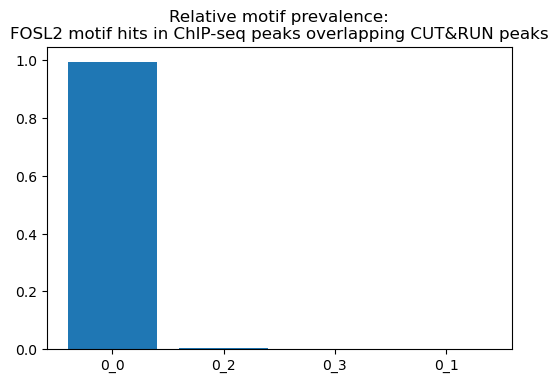

In [163]:
fig = plt.bar(x = FOSL2_motifs_chip_overlapping_cutnrun.name.unique(), 
              height = pd.value_counts(FOSL2_motifs_chip_overlapping_cutnrun.name) / len(FOSL2_motifs_chip_overlapping_cutnrun.name))
fig = plt.title('Relative motif prevalence:\nFOSL2 motif hits in ChIP-seq peaks overlapping CUT&RUN peaks')

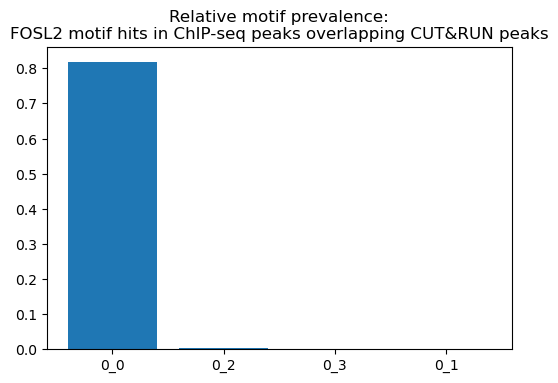

In [20]:
fig = plt.bar(x = FOSL2_motifs_chip_overlapping_cutnrun.name.unique(), 
              height = pd.value_counts(FOSL2_motifs_chip_overlapping_cutnrun.name) / len(FOSL2_motifs_chip))
fig = plt.title('Relative motif prevalence:\nFOSL2 motif hits in ChIP-seq peaks overlapping CUT&RUN peaks')

## b) Is there a correlation of these unique/shared peaks with other genomic features (i.e. DNase-seq, ATAC-seq, MNase-seq, etc.)?

#### game plannnn

1. Intersect all the motif hits with unique peaks vs shared peaks
2. Graph distribution of motif pattern indices by peak's assay type. Also graph by where motif hits came from (cutnrun model vs chipseq) 

SO i will end up with 2 graphs per TF\
Graph 1: motif hits from CUT&RUN\
Graph 2: motif hits from ChIP-seq

x axis will be categorical: motif patterns, e..g, 0_0 and 0_1\
y axis will be percent of overlapping motif hits \
bars will be for CUT&RUN vs ChIP-seq unique vs shared peaks (4 different bars)

In [9]:
# Load in assay peaks
assay_bed_paths = ['/home/katie/bp_repo/research/data/other-assays/A549/ATAC-peaks/ENCFF899OMR.bed.gz',
                   '/home/katie/bp_repo/research/data/other-assays/A549/DNase-peaks/ENCFF128ZVL.bed.gz',
                   '/home/katie/bp_repo/research/data/other-assays/A549/H3K27ac-histone-marks/ENCFF747IZX.bed.gz',
                   '/home/katie/bp_repo/research/data/other-assays/A549/H3K4me3-histone-marks/ENCFF535EYL.bed.gz']
print("ATAC peaks path: %s" % assay_bed_paths[0])
print("DNASE peaks path: %s" % assay_bed_paths[1])
print("ac histone marks: %s" % assay_bed_paths[2])
print("me3 histone marks: %s" % assay_bed_paths[3])

ATAC peaks path: /home/katie/bp_repo/research/data/other-assays/A549/ATAC-peaks/ENCFF899OMR.bed.gz
DNASE peaks path: /home/katie/bp_repo/research/data/other-assays/A549/DNase-peaks/ENCFF128ZVL.bed.gz
ac histone marks: /home/katie/bp_repo/research/data/other-assays/A549/H3K27ac-histone-marks/ENCFF747IZX.bed.gz
me3 histone marks: /home/katie/bp_repo/research/data/other-assays/A549/H3K4me3-histone-marks/ENCFF535EYL.bed.gz


In [10]:
# Import assay peaks
atac_peak_table = import_peak_table([assay_bed_paths[0]])  # 278,564 peaks and TONS of peak lengths
dnase_peak_table = import_peak_table([assay_bed_paths[1]]) # 143,283 peaks and TONS of peak lengths
ac_peak_table = import_peak_table([assay_bed_paths[2]])    # 129,753 peaks and TONS of peak lengths
me3_peak_table = import_peak_table([assay_bed_paths[3]])   # 27,884 peaks and TONS of peak lengths

### ATAC-seq overlap

yes i did manually go through and check—the overlap counts are correct

In [12]:
# this only needs to be run once and saved then opened in the future as TSVs
# !bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/CTCF_unique_cutnrun_no_chip_overlap -b /home/katie/bp_repo/research/data/other-assays/A549/ATAC-peaks/ENCFF899OMR.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_3/CTCF/cutnrun_no_chip_peaks_atac_overlap
# !bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/CTCF_unique_chip_no_cutnrun_overlap -b /home/katie/bp_repo/research/data/other-assays/A549/ATAC-peaks/ENCFF899OMR.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_3/CTCF/chip_no_cutnrun_peaks_atac_overlap

ctcf_unique_cutnrun_atac_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_3/CTCF/cutnrun_no_chip_peaks_atac_overlap',  # 17,876 overlaps
                                sep='\t', header=None)
ctcf_unique_chipseq_atac_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_3/CTCF/chip_no_cutnrun_peaks_atac_overlap',  # 3,861 overlaps
                                sep='\t', header=None)

# this only needs to be run once and saved then opened in the future as TSVs
# !bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/FOSL2_unique_cutnrun_no_chip_overlap -b /home/katie/bp_repo/research/data/other-assays/A549/ATAC-peaks/ENCFF899OMR.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_3/FOSL2/cutnrun_no_chip_peaks_atac_overlap
# !bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/FOSL2_unique_chip_no_cutnrun_overlap -b /home/katie/bp_repo/research/data/other-assays/A549/ATAC-peaks/ENCFF899OMR.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_3/FOSL2/chip_no_cutnrun_peaks_atac_overlap

fosl2_unique_cutnrun_atac_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_3/FOSL2/cutnrun_no_chip_peaks_atac_overlap',  # 13,868 overlaps
                                sep='\t', header=None)
fosl2_unique_chipseq_atac_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_3/FOSL2/chip_no_cutnrun_peaks_atac_overlap',  # 4,878 overlaps
                                sep='\t', header=None)

In [13]:
# this only needs to be run once and saved then opened in the future as TSVs
# !bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/CTCF_unique_cutnrun_with_any_chip_overlap -b /home/katie/bp_repo/research/data/other-assays/A549/ATAC-peaks/ENCFF899OMR.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_3/CTCF/cutnrun_with_any_chip_peaks_atac_overlap
# !bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/CTCF_unique_chip_with_any_cutnrun_overlap -b /home/katie/bp_repo/research/data/other-assays/A549/ATAC-peaks/ENCFF899OMR.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_3/CTCF/chip_with_any_cutnrun_peaks_atac_overlap

ctcf_shared_cutnrun_atac_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_3/CTCF/cutnrun_with_any_chip_peaks_atac_overlap',  # 28,104 overlaps
                                sep='\t', header=None)
ctcf_shared_chipseq_atac_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_3/CTCF/chip_with_any_cutnrun_peaks_atac_overlap',  # 28,808 overlaps
                                sep='\t', header=None)

# this only needs to be run once and saved then opened in the future as TSVs
# !bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/FOSL2_unique_cutnrun_with_any_chip_overlap -b /home/katie/bp_repo/research/data/other-assays/A549/ATAC-peaks/ENCFF899OMR.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_3/FOSL2/cutnrun_with_any_chip_peaks_atac_overlap
# !bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/FOSL2_unique_chip_with_any_cutnrun_overlap -b /home/katie/bp_repo/research/data/other-assays/A549/ATAC-peaks/ENCFF899OMR.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_3/FOSL2/chip_with_any_cutnrun_peaks_atac_overlap

fosl2_shared_cutnrun_atac_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_3/FOSL2/cutnrun_with_any_chip_peaks_atac_overlap',  # 23,883 overlaps
                                sep='\t', header=None)
fosl2_shared_chipseq_atac_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_3/FOSL2/chip_with_any_cutnrun_peaks_atac_overlap',  # 24,685 overlaps
                                sep='\t', header=None)



### DNase-seq overlap

yes i did manually go through and check—the overlap counts are correct

In [14]:
# this only needs to be run once and saved then opened in the future as TSVs
# !bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/CTCF_unique_cutnrun_no_chip_overlap -b /home/katie/bp_repo/research/data/other-assays/A549/DNase-peaks/ENCFF128ZVL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_3/CTCF/cutnrun_no_chip_peaks_dnase_overlap
# !bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/CTCF_unique_chip_no_cutnrun_overlap -b /home/katie/bp_repo/research/data/other-assays/A549/DNase-peaks/ENCFF128ZVL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_3/CTCF/chip_no_cutnrun_peaks_dnase_overlap

ctcf_unique_cutnrun_dnase_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_3/CTCF/cutnrun_no_chip_peaks_dnase_overlap',  # 16,579 overlaps
                                sep='\t', header=None)
ctcf_unique_chipseq_dnase_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_3/CTCF/chip_no_cutnrun_peaks_dnase_overlap',  # 3,499 overlaps
                                sep='\t', header=None)

# this only needs to be run once and saved then opened in the future as TSVs
# !bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/FOSL2_unique_cutnrun_no_chip_overlap -b /home/katie/bp_repo/research/data/other-assays/A549/DNase-peaks/ENCFF128ZVL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_3/FOSL2/cutnrun_no_chip_peaks_dnase_overlap
# !bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/FOSL2_unique_chip_no_cutnrun_overlap -b /home/katie/bp_repo/research/data/other-assays/A549/DNase-peaks/ENCFF128ZVL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_3/FOSL2/chip_no_cutnrun_peaks_dnase_overlap

fosl2_unique_cutnrun_dnase_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_3/FOSL2/cutnrun_no_chip_peaks_dnase_overlap',  # 13,076 overlaps
                                sep='\t', header=None)
fosl2_unique_chipseq_dnase_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_3/FOSL2/chip_no_cutnrun_peaks_dnase_overlap',  # 5,289 overlaps
                                sep='\t', header=None)

In [15]:
# this only needs to be run once and saved then opened in the future as TSVs
# !bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/CTCF_unique_cutnrun_with_any_chip_overlap -b /home/katie/bp_repo/research/data/other-assays/A549/DNase-peaks/ENCFF128ZVL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_3/CTCF/cutnrun_with_any_chip_peaks_dnase_overlap
# !bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/CTCF_unique_chip_with_any_cutnrun_overlap -b /home/katie/bp_repo/research/data/other-assays/A549/DNase-peaks/ENCFF128ZVL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_3/CTCF/chip_with_any_cutnrun_peaks_dnase_overlap

ctcf_shared_cutnrun_dnase_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_3/CTCF/cutnrun_with_any_chip_peaks_dnase_overlap',  # 28,784 overlaps
                                sep='\t', header=None)
ctcf_shared_chipseq_dnase_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_3/CTCF/chip_with_any_cutnrun_peaks_dnase_overlap',  # 29,390 overlaps
                                sep='\t', header=None)

# this only needs to be run once and saved then opened in the future as TSVs
# !bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/FOSL2_unique_cutnrun_with_any_chip_overlap -b /home/katie/bp_repo/research/data/other-assays/A549/DNase-peaks/ENCFF128ZVL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_3/FOSL2/cutnrun_with_any_chip_peaks_dnase_overlap
# !bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/FOSL2_unique_chip_with_any_cutnrun_overlap -b /home/katie/bp_repo/research/data/other-assays/A549/DNase-peaks/ENCFF128ZVL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_3/FOSL2/chip_with_any_cutnrun_peaks_dnase_overlap

fosl2_shared_cutnrun_dnase_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_3/FOSL2/cutnrun_with_any_chip_peaks_dnase_overlap',  # 23,882 overlaps
                                sep='\t', header=None)
fosl2_shared_chipseq_dnase_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_3/FOSL2/chip_with_any_cutnrun_peaks_dnase_overlap',  # 24,627 overlaps
                                sep='\t', header=None)



In [16]:
# this only needs to be run once and saved then opened in the future as TSVs
# !bedtools intersect -u -a /home/katie/bp_repo/research/data/cutnrun/CTCF/CTCF.bed -b /home/katie/bp_repo/research/data/other-assays/A549/DNase-peaks/ENCFF128ZVL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_3/CTCF/cutnrun_all_peaks_dnase_overlap
# !bedtools intersect -u -a /home/katie/bp_repo/research/data/chip-seq/CTCF/CTCF.bed -b /home/katie/bp_repo/research/data/other-assays/A549/DNase-peaks/ENCFF128ZVL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_3/CTCF/chip_all_peaks_dnase_overlap

ctcf_all_cutnrun_dnase_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_3/CTCF/cutnrun_all_peaks_dnase_overlap',  # 45,363 overlaps
                                sep='\t', header=None)
ctcf_all_chipseq_dnase_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_3/CTCF/chip_all_peaks_dnase_overlap',  # 32,889 overlaps
                                sep='\t', header=None)

# this only needs to be run once and saved then opened in the future as TSVs
# !bedtools intersect -u -a /home/katie/bp_repo/research/data/cutnrun/FOSL2/FOSL2.bed -b /home/katie/bp_repo/research/data/other-assays/A549/DNase-peaks/ENCFF128ZVL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_3/FOSL2/cutnrun_all_peaks_dnase_overlap
# !bedtools intersect -u -a /home/katie/bp_repo/research/data/chip-seq/FOSL2/FOSL2.bed -b /home/katie/bp_repo/research/data/other-assays/A549/DNase-peaks/ENCFF128ZVL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_3/FOSL2/chip_all_peaks_dnase_overlap

fosl2_all_cutnrun_dnase_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_3/FOSL2/cutnrun_all_peaks_dnase_overlap',  # 36,958 overlaps
                                sep='\t', header=None)
fosl2_all_chipseq_dnase_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_3/FOSL2/chip_all_peaks_dnase_overlap',  # 29,916 overlaps
                                sep='\t', header=None)



### Ac overlap

yes i did manually go through and check—the overlap counts are correct

In [17]:
# this only needs to be run once and saved then opened in the future as TSVs
# !bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/CTCF_unique_cutnrun_no_chip_overlap -b /home/katie/bp_repo/research/data/other-assays/A549/H3K27ac-histone-marks/ENCFF747IZX.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_3/CTCF/cutnrun_no_chip_peaks_ac_overlap
# !bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/CTCF_unique_chip_no_cutnrun_overlap -b /home/katie/bp_repo/research/data/other-assays/A549/H3K27ac-histone-marks/ENCFF747IZX.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_3/CTCF/chip_no_cutnrun_peaks_ac_overlap

ctcf_unique_cutnrun_ac_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_3/CTCF/cutnrun_no_chip_peaks_ac_overlap',  # 13,570 overlaps
                                sep='\t', header=None)
ctcf_unique_chipseq_ac_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_3/CTCF/chip_no_cutnrun_peaks_ac_overlap',  # 1,455 overlaps
                                sep='\t', header=None)

# this only needs to be run once and saved then opened in the future as TSVs
# !bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/FOSL2_unique_cutnrun_no_chip_overlap -b /home/katie/bp_repo/research/data/other-assays/A549/H3K27ac-histone-marks/ENCFF747IZX.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_3/FOSL2/cutnrun_no_chip_peaks_ac_overlap
# !bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/FOSL2_unique_chip_no_cutnrun_overlap -b /home/katie/bp_repo/research/data/other-assays/A549/H3K27ac-histone-marks/ENCFF747IZX.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_3/FOSL2/chip_no_cutnrun_peaks_ac_overlap

fosl2_unique_cutnrun_ac_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_3/FOSL2/cutnrun_no_chip_peaks_ac_overlap',  # 11,995 overlaps
                                sep='\t', header=None)
fosl2_unique_chipseq_ac_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_3/FOSL2/chip_no_cutnrun_peaks_ac_overlap',  # 4,984 overlaps
                                sep='\t', header=None)

In [18]:
# this only needs to be run once and saved then opened in the future as TSVs
# !bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/CTCF_unique_cutnrun_with_any_chip_overlap -b /home/katie/bp_repo/research/data/other-assays/A549/H3K27ac-histone-marks/ENCFF747IZX.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_3/CTCF/cutnrun_with_any_chip_peaks_ac_overlap
# !bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/CTCF_unique_chip_with_any_cutnrun_overlap -b /home/katie/bp_repo/research/data/other-assays/A549/H3K27ac-histone-marks/ENCFF747IZX.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_3/CTCF/chip_with_any_cutnrun_peaks_ac_overlap

ctcf_shared_cutnrun_ac_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_3/CTCF/cutnrun_with_any_chip_peaks_ac_overlap',  # 12,190 overlaps
                                sep='\t', header=None)
ctcf_shared_chipseq_ac_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_3/CTCF/chip_with_any_cutnrun_peaks_ac_overlap',  # 12,117 overlaps
                                sep='\t', header=None)

# this only needs to be run once and saved then opened in the future as TSVs
# !bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/FOSL2_unique_cutnrun_with_any_chip_overlap -b /home/katie/bp_repo/research/data/other-assays/A549/H3K27ac-histone-marks/ENCFF747IZX.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_3/FOSL2/cutnrun_with_any_chip_peaks_ac_overlap
# !bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/FOSL2_unique_chip_with_any_cutnrun_overlap -b /home/katie/bp_repo/research/data/other-assays/A549/H3K27ac-histone-marks/ENCFF747IZX.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_3/FOSL2/chip_with_any_cutnrun_peaks_ac_overlap

fosl2_shared_cutnrun_ac_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_3/FOSL2/cutnrun_with_any_chip_peaks_ac_overlap',  # 22,949 overlaps
                                sep='\t', header=None)
fosl2_shared_chipseq_ac_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_3/FOSL2/chip_with_any_cutnrun_peaks_ac_overlap',  # 23,550 overlaps
                                sep='\t', header=None)



### Me3 overlap

yes i did manually go through and check—the overlap counts are correct

In [19]:
# this only needs to be run once and saved then opened in the future as TSVs
# !bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/CTCF_unique_cutnrun_no_chip_overlap -b /home/katie/bp_repo/research/data/other-assays/A549/H3K4me3-histone-marks/ENCFF535EYL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_3/CTCF/cutnrun_no_chip_peaks_me3_overlap
# !bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/CTCF_unique_chip_no_cutnrun_overlap -b /home/katie/bp_repo/research/data/other-assays/A549/H3K4me3-histone-marks/ENCFF535EYL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_3/CTCF/chip_no_cutnrun_peaks_me3_overlap

ctcf_unique_cutnrun_me3_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_3/CTCF/cutnrun_no_chip_peaks_me3_overlap',  # 8,115 overlaps
                                sep='\t', header=None)
ctcf_unique_chipseq_me3_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_3/CTCF/chip_no_cutnrun_peaks_me3_overlap',  # 680 overlaps
                                sep='\t', header=None)

# this only needs to be run once and saved then opened in the future as TSVs
# !bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/FOSL2_unique_cutnrun_no_chip_overlap -b /home/katie/bp_repo/research/data/other-assays/A549/H3K4me3-histone-marks/ENCFF535EYL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_3/FOSL2/cutnrun_no_chip_peaks_me3_overlap
# !bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/FOSL2_unique_chip_no_cutnrun_overlap -b /home/katie/bp_repo/research/data/other-assays/A549/H3K4me3-histone-marks/ENCFF535EYL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_3/FOSL2/chip_no_cutnrun_peaks_me3_overlap

fosl2_unique_cutnrun_me3_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_3/FOSL2/cutnrun_no_chip_peaks_me3_overlap',  # 5,447 overlaps
                                sep='\t', header=None)
fosl2_unique_chipseq_me3_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_3/FOSL2/chip_no_cutnrun_peaks_me3_overlap',  # 1,388 overlaps
                                sep='\t', header=None)

In [20]:
# this only needs to be run once and saved then opened in the future as TSVs
# !bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/CTCF_unique_cutnrun_with_any_chip_overlap -b /home/katie/bp_repo/research/data/other-assays/A549/H3K4me3-histone-marks/ENCFF535EYL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_3/CTCF/cutnrun_with_any_chip_peaks_me3_overlap
# !bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/CTCF_unique_chip_with_any_cutnrun_overlap -b /home/katie/bp_repo/research/data/other-assays/A549/H3K4me3-histone-marks/ENCFF535EYL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_3/CTCF/chip_with_any_cutnrun_peaks_me3_overlap

ctcf_shared_cutnrun_me3_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_3/CTCF/cutnrun_with_any_chip_peaks_me3_overlap',  # 5,946 overlaps
                                sep='\t', header=None)
ctcf_shared_chipseq_me3_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_3/CTCF/chip_with_any_cutnrun_peaks_me3_overlap',  # 6,072 overlaps
                                sep='\t', header=None)

# this only needs to be run once and saved then opened in the future as TSVs
# !bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/FOSL2_unique_cutnrun_with_any_chip_overlap -b /home/katie/bp_repo/research/data/other-assays/A549/H3K4me3-histone-marks/ENCFF535EYL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_3/FOSL2/cutnrun_with_any_chip_peaks_me3_overlap
# !bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/FOSL2_unique_chip_with_any_cutnrun_overlap -b /home/katie/bp_repo/research/data/other-assays/A549/H3K4me3-histone-marks/ENCFF535EYL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_3/FOSL2/chip_with_any_cutnrun_peaks_me3_overlap

fosl2_shared_cutnrun_me3_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_3/FOSL2/cutnrun_with_any_chip_peaks_me3_overlap',  # 8,266 overlaps
                                sep='\t', header=None)
fosl2_shared_chipseq_me3_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_3/FOSL2/chip_with_any_cutnrun_peaks_me3_overlap',  # 8,499 overlaps
                                sep='\t', header=None)



## GRAPHING

In [21]:
plt.rcParams['figure.dpi'] = 200

In [22]:
def roundd(listy, sigfigs=2):
    ''' given a list of numbers, round them all to 2 decimals and return a new list '''
    return list(round(i, sigfigs) for i in listy)

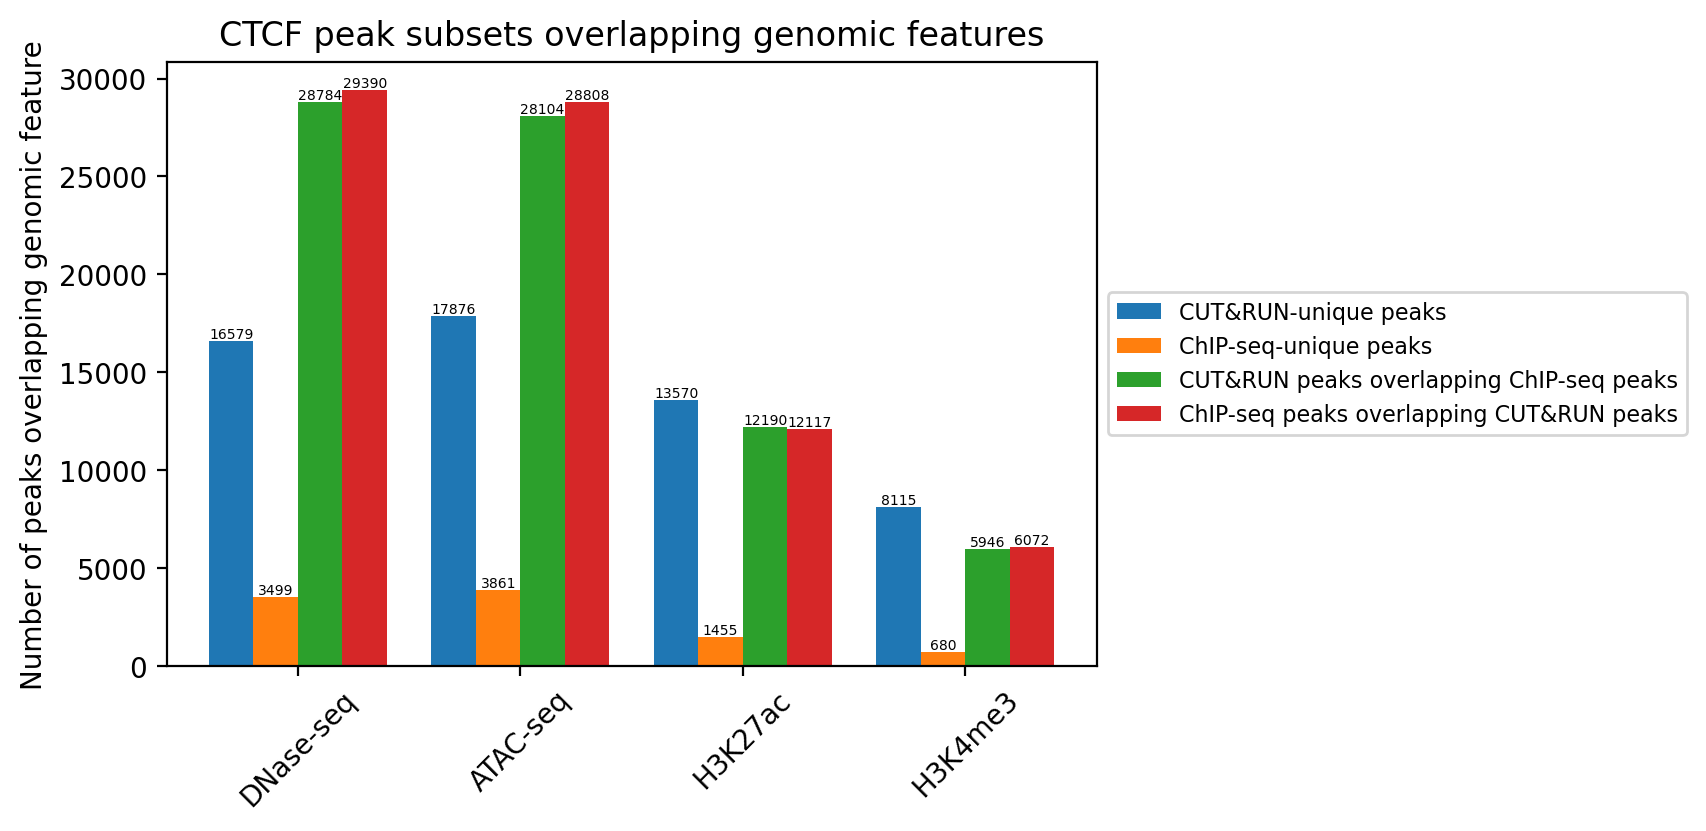

In [23]:
# CTCF
## PLOTTING RAW NUMBERS

labels = ['DNase-seq', 'ATAC-seq', 'H3K27ac', 'H3K4me3']

# cutnrun unique peaks, all assays
cutnrun_unique_relative_to_all_peaks = [len(ctcf_unique_cutnrun_dnase_overlap),
                                 len(ctcf_unique_cutnrun_atac_overlap),
                                 len(ctcf_unique_cutnrun_ac_overlap),
                                 len(ctcf_unique_cutnrun_me3_overlap)]

# chipseq unique peaks, all assays
chip_unique_relative_to_all_peaks = [len(ctcf_unique_chipseq_dnase_overlap),
                                 len(ctcf_unique_chipseq_atac_overlap),
                                 len(ctcf_unique_chipseq_ac_overlap),
                                 len(ctcf_unique_chipseq_me3_overlap)]

# cutnrun shared peaks, all assays
cutnrun_shared_relative_to_all_peaks = [len(ctcf_shared_cutnrun_dnase_overlap),
                                 len(ctcf_shared_cutnrun_atac_overlap),
                                 len(ctcf_shared_cutnrun_ac_overlap),
                                 len(ctcf_shared_cutnrun_me3_overlap)]

# chipseq shared peaks, all assays
chip_shared_relative_to_all_peaks = [len(ctcf_shared_chipseq_dnase_overlap),
                                 len(ctcf_shared_chipseq_atac_overlap),
                                 len(ctcf_shared_chipseq_ac_overlap),
                                 len(ctcf_shared_chipseq_me3_overlap)]

width = 0.2       # the width of the bars: can also be len(x) sequence
ind = np.arange(len(labels))

fig, ax = plt.subplots()

# CUT&RUN unique peaks, all assays
rects1 = ax.bar(ind - 3*width/2, roundd(cutnrun_unique_relative_to_all_peaks), width, label='CUT&RUN-unique peaks')

# ChIP-seq unique peaks, all assays
rects3 = ax.bar(ind - width/2, roundd(chip_unique_relative_to_all_peaks), width, label='ChIP-seq-unique peaks')

# CUT&RUN peaks overlapping ChIP-seq peaks, all assays
rects5 = ax.bar(ind + width/2, roundd(cutnrun_shared_relative_to_all_peaks), width, label='CUT&RUN peaks overlapping ChIP-seq peaks')

# ChIP-seq peaks overlapping CUT&RUN peaks, all assays
rects7 = ax.bar(ind + 3*width/2, roundd(chip_shared_relative_to_all_peaks), width, label='ChIP-seq peaks overlapping CUT&RUN peaks')

ax.set_xticks(ind, labels, rotation=45)
ax.set_ylabel('Number of peaks overlapping genomic feature')
ax.set_title('CTCF peak subsets overlapping genomic features')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 8})

ax.bar_label(rects1, padding=0, fontsize=5)
ax.bar_label(rects3, padding=0, fontsize=5)
ax.bar_label(rects5, padding=0, fontsize=5)
ax.bar_label(rects7, padding=0, fontsize=5)


plt.show()

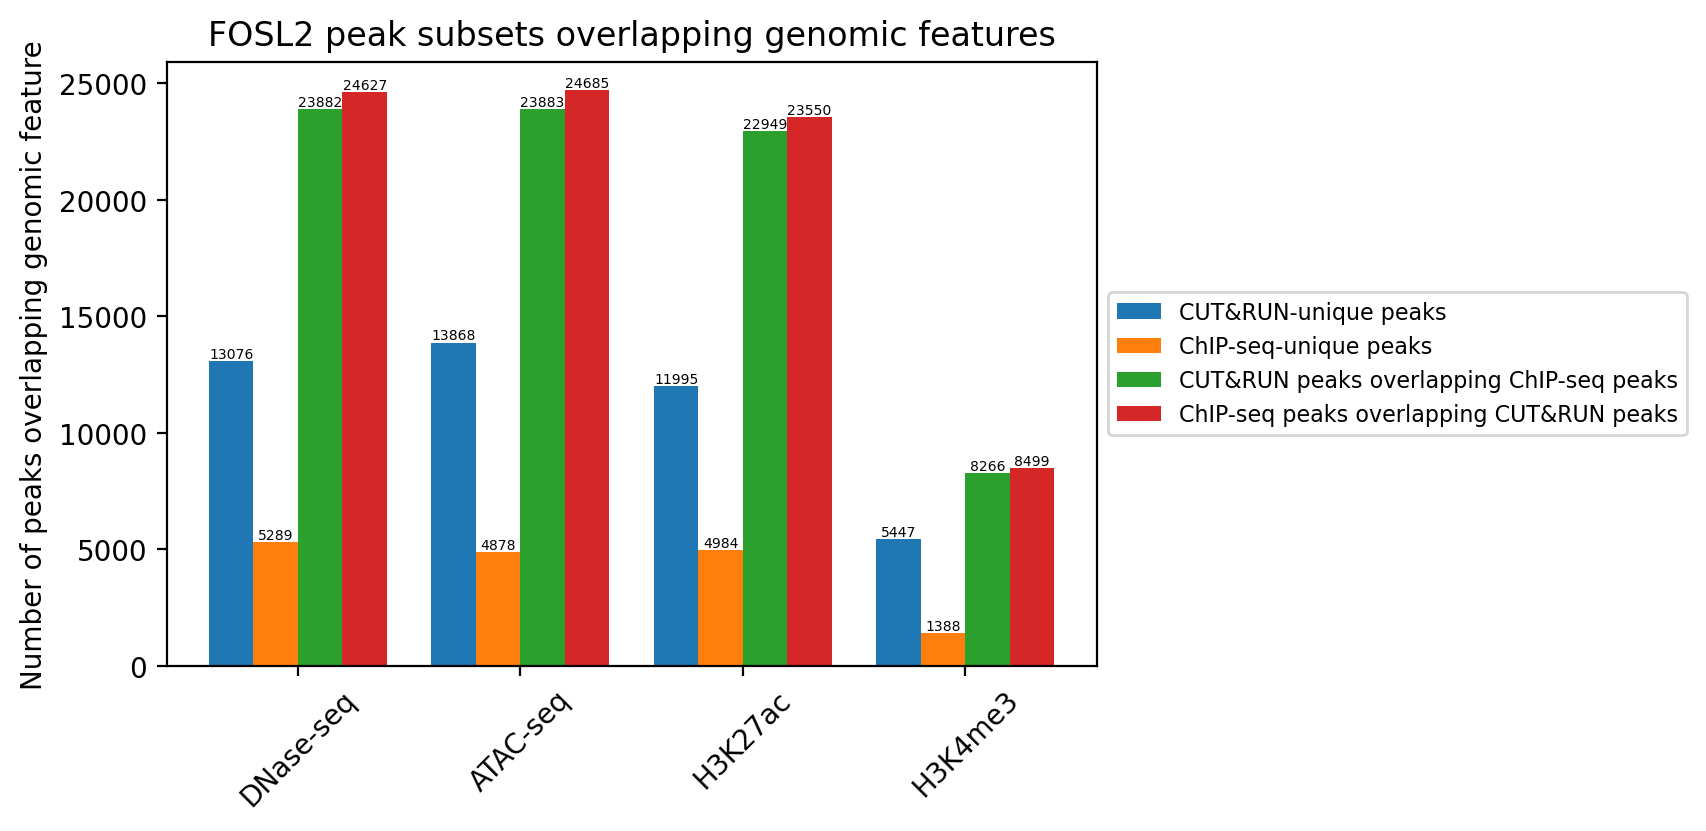

In [357]:
# FOSL2
## PLOTTING RAW NUMBERS

labels = ['DNase-seq', 'ATAC-seq', 'H3K27ac', 'H3K4me3']

# cutnrun unique peaks, all assays
cutnrun_unique_relative_to_all_peaks = [len(fosl2_unique_cutnrun_dnase_overlap),
                                 len(fosl2_unique_cutnrun_atac_overlap),
                                 len(fosl2_unique_cutnrun_ac_overlap),
                                 len(fosl2_unique_cutnrun_me3_overlap)]

# chipseq unique peaks, all assays
chip_unique_relative_to_all_peaks = [len(fosl2_unique_chipseq_dnase_overlap),
                                 len(fosl2_unique_chipseq_atac_overlap),
                                 len(fosl2_unique_chipseq_ac_overlap),
                                 len(fosl2_unique_chipseq_me3_overlap)]

# cutnrun shared peaks, all assays
cutnrun_shared_relative_to_all_peaks = [len(fosl2_shared_cutnrun_dnase_overlap),
                                 len(fosl2_shared_cutnrun_atac_overlap),
                                 len(fosl2_shared_cutnrun_ac_overlap),
                                 len(fosl2_shared_cutnrun_me3_overlap)]

# chipseq shared peaks, all assays
chip_shared_relative_to_all_peaks = [len(fosl2_shared_chipseq_dnase_overlap),
                                 len(fosl2_shared_chipseq_atac_overlap),
                                 len(fosl2_shared_chipseq_ac_overlap),
                                 len(fosl2_shared_chipseq_me3_overlap)]

width = 0.2       # the width of the bars: can also be len(x) sequence
ind = np.arange(len(labels))

fig, ax = plt.subplots()

# CUT&RUN unique peaks, all assays
rects1 = ax.bar(ind - 3*width/2, roundd(cutnrun_unique_relative_to_all_peaks), width, label='CUT&RUN-unique peaks')

# ChIP-seq unique peaks, all assays
rects3 = ax.bar(ind - width/2, roundd(chip_unique_relative_to_all_peaks), width, label='ChIP-seq-unique peaks')

# CUT&RUN peaks overlapping ChIP-seq peaks, all assays
rects5 = ax.bar(ind + width/2, roundd(cutnrun_shared_relative_to_all_peaks), width, label='CUT&RUN peaks overlapping ChIP-seq peaks')

# ChIP-seq peaks overlapping CUT&RUN peaks, all assays
rects7 = ax.bar(ind + 3*width/2, roundd(chip_shared_relative_to_all_peaks), width, label='ChIP-seq peaks overlapping CUT&RUN peaks')

ax.set_xticks(ind, labels, rotation=45)
ax.set_ylabel('Number of peaks overlapping genomic feature')
ax.set_title('FOSL2 peak subsets overlapping genomic features')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 8})

ax.bar_label(rects1, padding=0, fontsize=5)
ax.bar_label(rects3, padding=0, fontsize=5)
ax.bar_label(rects5, padding=0, fontsize=5)
ax.bar_label(rects7, padding=0, fontsize=5)


plt.show()

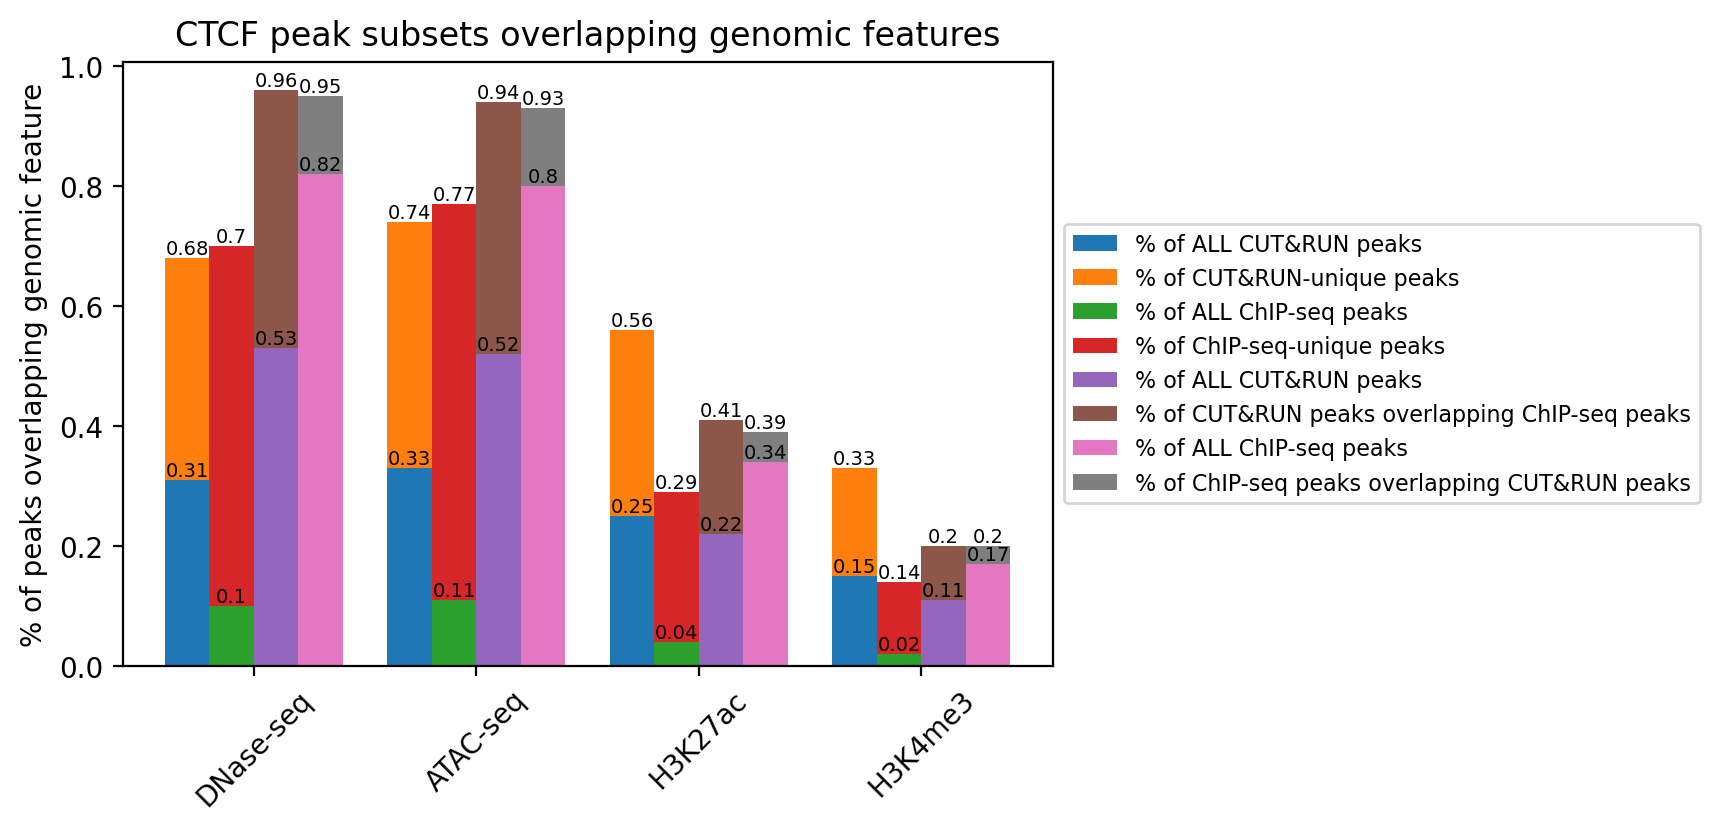

In [361]:
# CTCF
## PLOTTING BY PERCENTAGE OF PEAKS

labels = ['DNase-seq', 'ATAC-seq', 'H3K27ac', 'H3K4me3']

# cutnrun unique peaks, all assays
cutnrun_unique_relative_to_all_peaks = [len(ctcf_unique_cutnrun_dnase_overlap) / len(CTCF_cutnrun),
                                 len(ctcf_unique_cutnrun_atac_overlap) / len(CTCF_cutnrun),
                                 len(ctcf_unique_cutnrun_ac_overlap) / len(CTCF_cutnrun),
                                 len(ctcf_unique_cutnrun_me3_overlap) / len(CTCF_cutnrun)]
cutnrun_unique_relative_to_subset_peaks = list(i * len(CTCF_cutnrun) / len(CTCF_unique_cutnrun) for i in cutnrun_unique_relative_to_all_peaks)

# chipseq unique peaks, all assays
chip_unique_relative_to_all_peaks = [len(ctcf_unique_chipseq_dnase_overlap) / len(CTCF_chip),
                                 len(ctcf_unique_chipseq_atac_overlap) / len(CTCF_chip),
                                 len(ctcf_unique_chipseq_ac_overlap) / len(CTCF_chip),
                                 len(ctcf_unique_chipseq_me3_overlap) / len(CTCF_chip)]
chip_unique_relative_to_subset_peaks = list(i * len(CTCF_chip) / len(CTCF_unique_chipseq) for i in chip_unique_relative_to_all_peaks)

# cutnrun shared peaks, all assays
cutnrun_shared_relative_to_all_peaks = [len(ctcf_shared_cutnrun_dnase_overlap) / len(CTCF_cutnrun),
                                 len(ctcf_shared_cutnrun_atac_overlap) / len(CTCF_cutnrun),
                                 len(ctcf_shared_cutnrun_ac_overlap) / len(CTCF_cutnrun),
                                 len(ctcf_shared_cutnrun_me3_overlap) / len(CTCF_cutnrun)]
cutnrun_shared_relative_to_subset_peaks = list(i * len(CTCF_cutnrun) / len(CTCF_cutnrun_overlapping_chip) for i in cutnrun_shared_relative_to_all_peaks)

# chipseq shared peaks, all assays
chip_shared_relative_to_all_peaks = [len(ctcf_shared_chipseq_dnase_overlap) / len(CTCF_chip),
                                 len(ctcf_shared_chipseq_atac_overlap) / len(CTCF_chip),
                                 len(ctcf_shared_chipseq_ac_overlap) / len(CTCF_chip),
                                 len(ctcf_shared_chipseq_me3_overlap) / len(CTCF_chip)]
chip_shared_relative_to_subset_peaks = list(i * len(CTCF_chip) / len(CTCF_chip_overlapping_cutnrun) for i in chip_shared_relative_to_all_peaks)

width = 0.2       # the width of the bars: can also be len(x) sequence
ind = np.arange(len(labels))

fig, ax = plt.subplots()

# CUT&RUN unique peaks, all assays
rects1 = ax.bar(ind - 3*width/2, roundd(cutnrun_unique_relative_to_all_peaks), width, label='% of ALL CUT&RUN peaks')
rects2 = ax.bar(ind - 3*width/2, roundd(cutnrun_unique_relative_to_subset_peaks), width, zorder=0,
       label='% of CUT&RUN-unique peaks')

# ChIP-seq unique peaks, all assays
rects3 = ax.bar(ind - width/2, roundd(chip_unique_relative_to_all_peaks), width, label='% of ALL ChIP-seq peaks')
rects4 = ax.bar(ind - width/2, roundd(chip_unique_relative_to_subset_peaks), width, zorder=0,
       label='% of ChIP-seq-unique peaks')

# CUT&RUN peaks overlapping ChIP-seq peaks, all assays
rects5 = ax.bar(ind + width/2, roundd(cutnrun_shared_relative_to_all_peaks), width, label='% of ALL CUT&RUN peaks')
rects6 = ax.bar(ind + width/2, roundd(cutnrun_shared_relative_to_subset_peaks), width, zorder=0,
       label='% of CUT&RUN peaks overlapping ChIP-seq peaks')

# ChIP-seq peaks overlapping CUT&RUN peaks, all assays
rects7 = ax.bar(ind + 3*width/2, roundd(chip_shared_relative_to_all_peaks), width, label='% of ALL ChIP-seq peaks')
rects8 = ax.bar(ind + 3*width/2, roundd(chip_shared_relative_to_subset_peaks), width, zorder=0,
       label='% of ChIP-seq peaks overlapping CUT&RUN peaks')

ax.set_xticks(ind, labels, rotation=45)
ax.set_ylabel('% of peaks overlapping genomic feature')
ax.set_title('CTCF peak subsets overlapping genomic features')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 8})

ax.bar_label(rects1, padding=0, fontsize=7)
ax.bar_label(rects2, padding=0, fontsize=7)
ax.bar_label(rects3, padding=0, fontsize=7)
ax.bar_label(rects4, padding=0, fontsize=7)
ax.bar_label(rects5, padding=0, fontsize=7)
ax.bar_label(rects6, padding=0, fontsize=7)
ax.bar_label(rects7, padding=0, fontsize=7)
ax.bar_label(rects8, padding=0, fontsize=7)


plt.show()

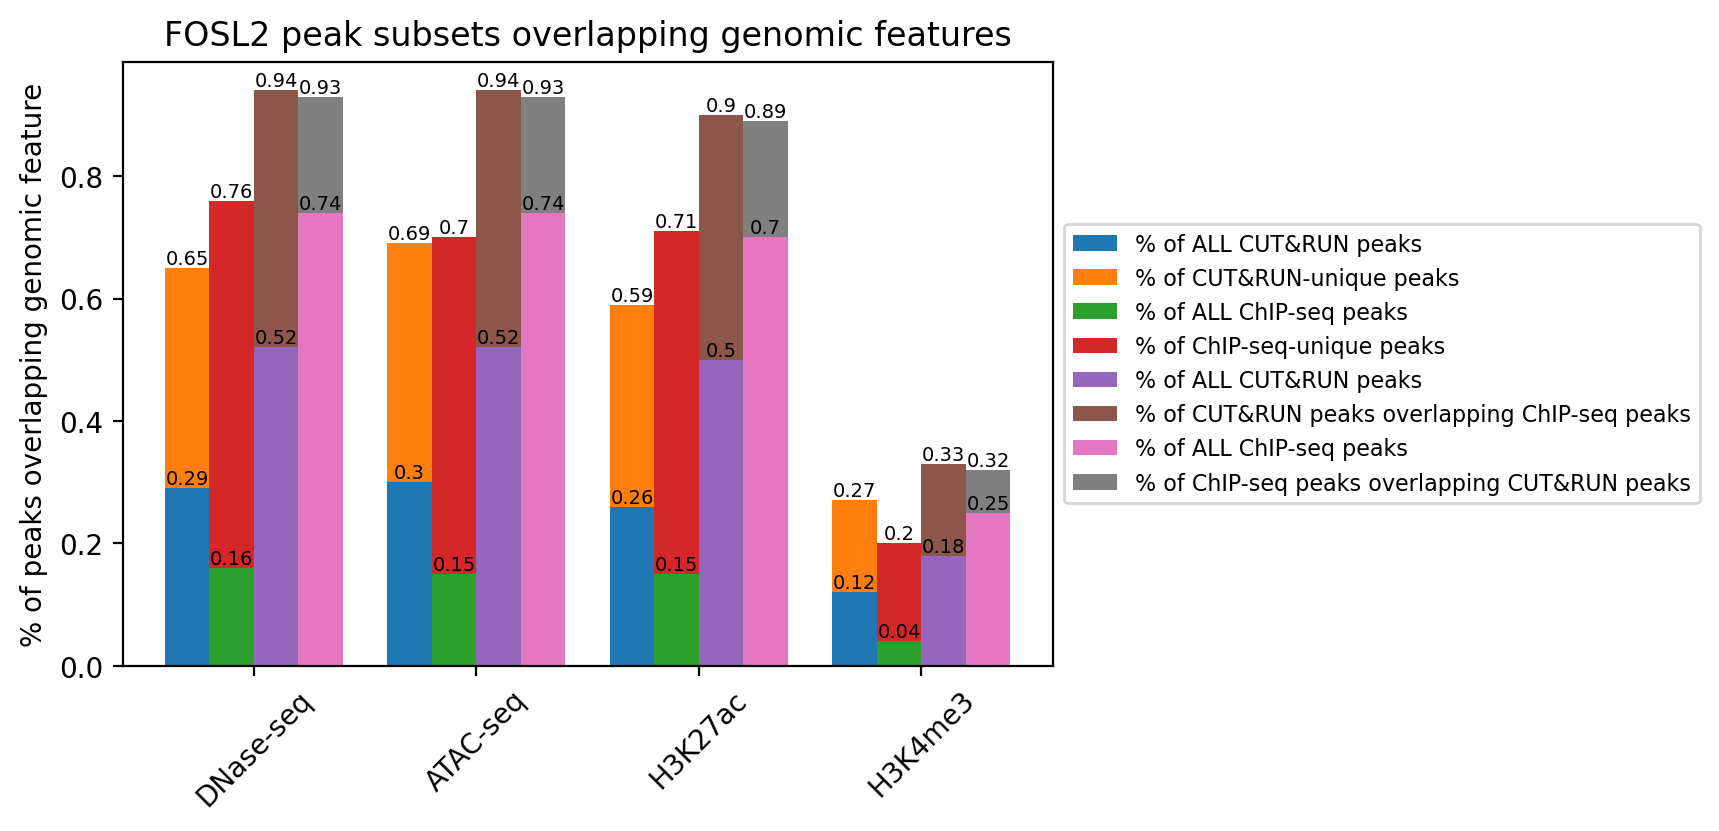

In [360]:
# FOSL2
## PLOTTING BY PERCENTAGE OF PEAKS

labels = ['DNase-seq', 'ATAC-seq', 'H3K27ac', 'H3K4me3']

# cutnrun unique peaks, all assays
cutnrun_unique_relative_to_all_peaks = [len(fosl2_unique_cutnrun_dnase_overlap) / len(FOSL2_cutnrun),
                                 len(fosl2_unique_cutnrun_atac_overlap) / len(FOSL2_cutnrun),
                                 len(fosl2_unique_cutnrun_ac_overlap) / len(FOSL2_cutnrun),
                                 len(fosl2_unique_cutnrun_me3_overlap) / len(FOSL2_cutnrun)]
cutnrun_unique_relative_to_subset_peaks = list(i * len(FOSL2_cutnrun) / len(FOSL2_unique_cutnrun) for i in cutnrun_unique_relative_to_all_peaks)

# chipseq unique peaks, all assays
chip_unique_relative_to_all_peaks = [len(fosl2_unique_chipseq_dnase_overlap) / len(FOSL2_chip),
                                 len(fosl2_unique_chipseq_atac_overlap) / len(FOSL2_chip),
                                 len(fosl2_unique_chipseq_ac_overlap) / len(FOSL2_chip),
                                 len(fosl2_unique_chipseq_me3_overlap) / len(FOSL2_chip)]
chip_unique_relative_to_subset_peaks = list(i * len(FOSL2_chip) / len(FOSL2_unique_chipseq) for i in chip_unique_relative_to_all_peaks)

# cutnrun shared peaks, all assays
cutnrun_shared_relative_to_all_peaks = [len(fosl2_shared_cutnrun_dnase_overlap) / len(FOSL2_cutnrun),
                                 len(fosl2_shared_cutnrun_atac_overlap) / len(FOSL2_cutnrun),
                                 len(fosl2_shared_cutnrun_ac_overlap) / len(FOSL2_cutnrun),
                                 len(fosl2_shared_cutnrun_me3_overlap) / len(FOSL2_cutnrun)]
cutnrun_shared_relative_to_subset_peaks = list(i * len(FOSL2_cutnrun) / len(FOSL2_cutnrun_overlapping_chip) for i in cutnrun_shared_relative_to_all_peaks)

# chipseq shared peaks, all assays
chip_shared_relative_to_all_peaks = [len(fosl2_shared_chipseq_dnase_overlap) / len(FOSL2_chip),
                                 len(fosl2_shared_chipseq_atac_overlap) / len(FOSL2_chip),
                                 len(fosl2_shared_chipseq_ac_overlap) / len(FOSL2_chip),
                                 len(fosl2_shared_chipseq_me3_overlap) / len(FOSL2_chip)]
chip_shared_relative_to_subset_peaks = list(i * len(FOSL2_chip) / len(FOSL2_chip_overlapping_cutnrun) for i in chip_shared_relative_to_all_peaks)

width = 0.2       # the width of the bars: can also be len(x) sequence
ind = np.arange(len(labels))

fig, ax = plt.subplots()

# CUT&RUN unique peaks, all assays
rects1 = ax.bar(ind - 3*width/2, roundd(cutnrun_unique_relative_to_all_peaks), width, label='% of ALL CUT&RUN peaks')
rects2 = ax.bar(ind - 3*width/2, roundd(cutnrun_unique_relative_to_subset_peaks), width, zorder=0,
        label='% of CUT&RUN-unique peaks')

# ChIP-seq unique peaks, all assays
rects3 = ax.bar(ind - width/2, roundd(chip_unique_relative_to_all_peaks), width, label='% of ALL ChIP-seq peaks')
rects4 = ax.bar(ind - width/2, roundd(chip_unique_relative_to_subset_peaks), width, zorder=0,
        label='% of ChIP-seq-unique peaks')

# CUT&RUN peaks overlapping ChIP-seq peaks, all assays
rects5 = ax.bar(ind + width/2, roundd(cutnrun_shared_relative_to_all_peaks), width, label='% of ALL CUT&RUN peaks')
rects6 = ax.bar(ind + width/2, roundd(cutnrun_shared_relative_to_subset_peaks), width, zorder=0,
        label='% of CUT&RUN peaks overlapping ChIP-seq peaks')

# ChIP-seq peaks overlapping CUT&RUN peaks, all assays
rects7 = ax.bar(ind + 3*width/2, roundd(chip_shared_relative_to_all_peaks), width, label='% of ALL ChIP-seq peaks')
rects8 = ax.bar(ind + 3*width/2, roundd(chip_shared_relative_to_subset_peaks), width, zorder=0,
        label='% of ChIP-seq peaks overlapping CUT&RUN peaks')

ax.set_xticks(ind, labels, rotation=45)
ax.set_ylabel('% of peaks overlapping genomic feature')
ax.set_title('FOSL2 peak subsets overlapping genomic features')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 8})

ax.bar_label(rects1, padding=0, fontsize=7)
ax.bar_label(rects2, padding=0, fontsize=7)
ax.bar_label(rects3, padding=0, fontsize=7)
ax.bar_label(rects4, padding=0, fontsize=7)
ax.bar_label(rects5, padding=0, fontsize=7)
ax.bar_label(rects6, padding=0, fontsize=7)
ax.bar_label(rects7, padding=0, fontsize=7)
ax.bar_label(rects8, padding=0, fontsize=7)


plt.show()

## May 3 meeting stuff

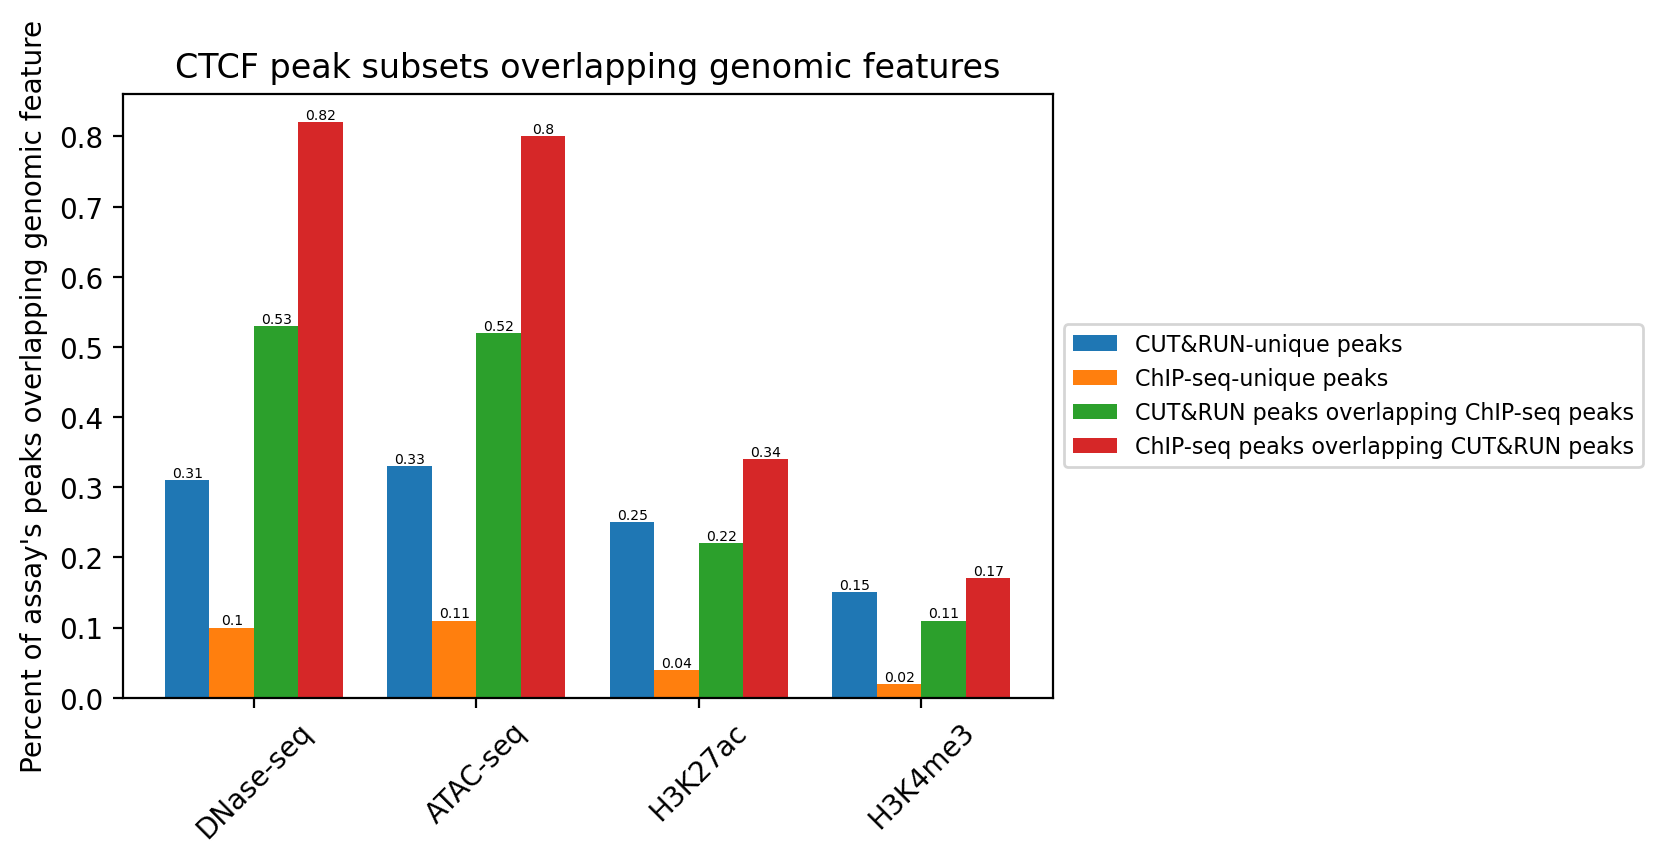

In [26]:
# CTCF
## PLOTTING PERCENTAGES (where denominator is all CUT&RUN or all ChIP-seq peaks)

labels = ['DNase-seq', 'ATAC-seq', 'H3K27ac', 'H3K4me3']

# cutnrun unique peaks, all assays
cutnrun_unique_relative_to_all_peaks = [len(ctcf_unique_cutnrun_dnase_overlap) / len(CTCF_cutnrun),
                                 len(ctcf_unique_cutnrun_atac_overlap) / len(CTCF_cutnrun),
                                 len(ctcf_unique_cutnrun_ac_overlap) / len(CTCF_cutnrun),
                                 len(ctcf_unique_cutnrun_me3_overlap) / len(CTCF_cutnrun)]

# chipseq unique peaks, all assays
chip_unique_relative_to_all_peaks = [len(ctcf_unique_chipseq_dnase_overlap) / len(CTCF_chip),
                                 len(ctcf_unique_chipseq_atac_overlap) / len(CTCF_chip),
                                 len(ctcf_unique_chipseq_ac_overlap) / len(CTCF_chip),
                                 len(ctcf_unique_chipseq_me3_overlap) / len(CTCF_chip)]

# cutnrun shared peaks, all assays
cutnrun_shared_relative_to_all_peaks = [len(ctcf_shared_cutnrun_dnase_overlap) / len(CTCF_cutnrun),
                                 len(ctcf_shared_cutnrun_atac_overlap) / len(CTCF_cutnrun),
                                 len(ctcf_shared_cutnrun_ac_overlap) / len(CTCF_cutnrun),
                                 len(ctcf_shared_cutnrun_me3_overlap) / len(CTCF_cutnrun)]

# chipseq shared peaks, all assays
chip_shared_relative_to_all_peaks = [len(ctcf_shared_chipseq_dnase_overlap) / len(CTCF_chip),
                                 len(ctcf_shared_chipseq_atac_overlap) / len(CTCF_chip),
                                 len(ctcf_shared_chipseq_ac_overlap) / len(CTCF_chip),
                                 len(ctcf_shared_chipseq_me3_overlap) / len(CTCF_chip)]

width = 0.2       # the width of the bars: can also be len(x) sequence
ind = np.arange(len(labels))

fig, ax = plt.subplots()

# CUT&RUN unique peaks, all assays
rects1 = ax.bar(ind - 3*width/2, roundd(cutnrun_unique_relative_to_all_peaks), width, label='CUT&RUN-unique peaks')

# ChIP-seq unique peaks, all assays
rects3 = ax.bar(ind - width/2, roundd(chip_unique_relative_to_all_peaks), width, label='ChIP-seq-unique peaks')

# CUT&RUN peaks overlapping ChIP-seq peaks, all assays
rects5 = ax.bar(ind + width/2, roundd(cutnrun_shared_relative_to_all_peaks), width, label='CUT&RUN peaks overlapping ChIP-seq peaks')

# ChIP-seq peaks overlapping CUT&RUN peaks, all assays
rects7 = ax.bar(ind + 3*width/2, roundd(chip_shared_relative_to_all_peaks), width, label='ChIP-seq peaks overlapping CUT&RUN peaks')

ax.set_xticks(ind, labels, rotation=45)
ax.set_ylabel("Percent of assay's peaks overlapping genomic feature")
ax.set_title('CTCF peak subsets overlapping genomic features')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 8})

ax.bar_label(rects1, padding=0, fontsize=5)
ax.bar_label(rects3, padding=0, fontsize=5)
ax.bar_label(rects5, padding=0, fontsize=5)
ax.bar_label(rects7, padding=0, fontsize=5)


plt.show()

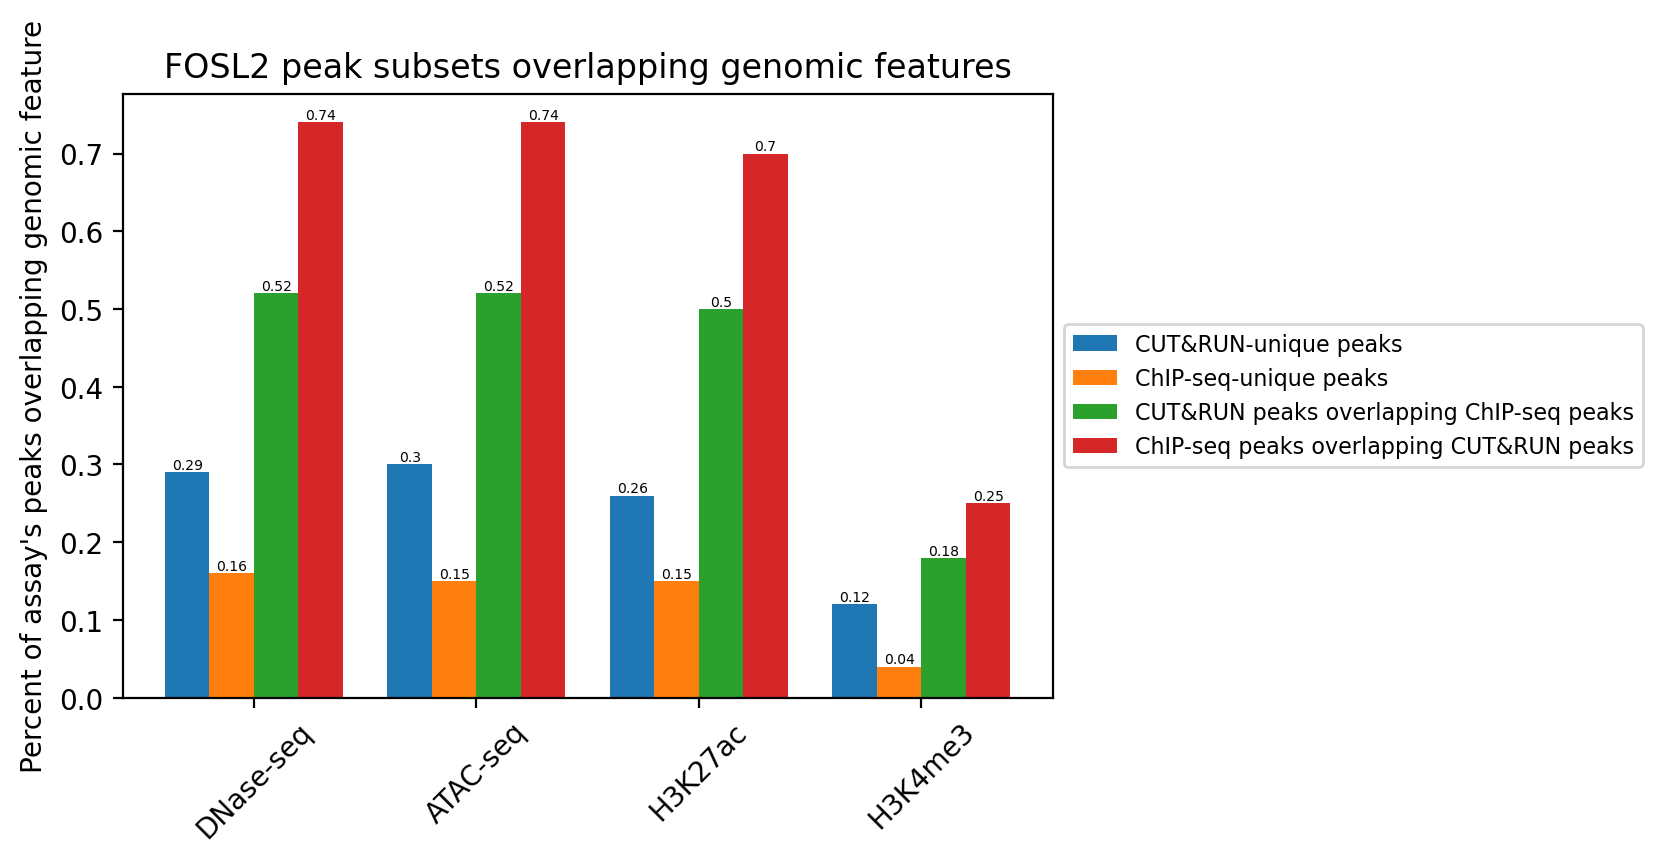

In [27]:
# FOSL2
## PLOTTING RAW NUMBERS

labels = ['DNase-seq', 'ATAC-seq', 'H3K27ac', 'H3K4me3']

# cutnrun unique peaks, all assays
cutnrun_unique_relative_to_all_peaks = [len(fosl2_unique_cutnrun_dnase_overlap) / len(FOSL2_cutnrun),
                                 len(fosl2_unique_cutnrun_atac_overlap) / len(FOSL2_cutnrun),
                                 len(fosl2_unique_cutnrun_ac_overlap) / len(FOSL2_cutnrun),
                                 len(fosl2_unique_cutnrun_me3_overlap) / len(FOSL2_cutnrun)]

# chipseq unique peaks, all assays
chip_unique_relative_to_all_peaks = [len(fosl2_unique_chipseq_dnase_overlap) / len(FOSL2_chip),
                                 len(fosl2_unique_chipseq_atac_overlap) / len(FOSL2_chip),
                                 len(fosl2_unique_chipseq_ac_overlap) / len(FOSL2_chip),
                                 len(fosl2_unique_chipseq_me3_overlap) / len(FOSL2_chip)]

# cutnrun shared peaks, all assays
cutnrun_shared_relative_to_all_peaks = [len(fosl2_shared_cutnrun_dnase_overlap) / len(FOSL2_cutnrun),
                                 len(fosl2_shared_cutnrun_atac_overlap) / len(FOSL2_cutnrun),
                                 len(fosl2_shared_cutnrun_ac_overlap) / len(FOSL2_cutnrun),
                                 len(fosl2_shared_cutnrun_me3_overlap) / len(FOSL2_cutnrun)]

# chipseq shared peaks, all assays
chip_shared_relative_to_all_peaks = [len(fosl2_shared_chipseq_dnase_overlap) / len(FOSL2_chip),
                                 len(fosl2_shared_chipseq_atac_overlap) / len(FOSL2_chip),
                                 len(fosl2_shared_chipseq_ac_overlap) / len(FOSL2_chip),
                                 len(fosl2_shared_chipseq_me3_overlap) / len(FOSL2_chip)]

width = 0.2       # the width of the bars: can also be len(x) sequence
ind = np.arange(len(labels))

fig, ax = plt.subplots()

# CUT&RUN unique peaks, all assays
rects1 = ax.bar(ind - 3*width/2, roundd(cutnrun_unique_relative_to_all_peaks), width, label='CUT&RUN-unique peaks')

# ChIP-seq unique peaks, all assays
rects3 = ax.bar(ind - width/2, roundd(chip_unique_relative_to_all_peaks), width, label='ChIP-seq-unique peaks')

# CUT&RUN peaks overlapping ChIP-seq peaks, all assays
rects5 = ax.bar(ind + width/2, roundd(cutnrun_shared_relative_to_all_peaks), width, label='CUT&RUN peaks overlapping ChIP-seq peaks')

# ChIP-seq peaks overlapping CUT&RUN peaks, all assays
rects7 = ax.bar(ind + 3*width/2, roundd(chip_shared_relative_to_all_peaks), width, label='ChIP-seq peaks overlapping CUT&RUN peaks')

ax.set_xticks(ind, labels, rotation=45)
ax.set_ylabel("Percent of assay's peaks overlapping genomic feature")
ax.set_title('FOSL2 peak subsets overlapping genomic features')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 8})

ax.bar_label(rects1, padding=0, fontsize=5)
ax.bar_label(rects3, padding=0, fontsize=5)
ax.bar_label(rects5, padding=0, fontsize=5)
ax.bar_label(rects7, padding=0, fontsize=5)


plt.show()